In [1]:
%load_ext autoreload
%autoreload 2

In this example we are going to train 3 image classifiers using the [BigEarthNet](http://bigearth.net/) dataset:

1. Using S1 images
2. Using S2 images
3. Using both S1 and S2 images in a Data Fusion configuration.

This dataset needs to be downloaded from the [BigEarthNet website](http://bigearth.net/). Once downloaded you will need a folder with the following structure:

- BigEarthNet-S1-v1.0
- BigEarthNet-v1.0 
- patches_with_cloud_and_shadow.csv
- patches_with_seasonal_snow.csv

Then you can instantiate the Dataset as follows, selecting the sensors and bands that you want to work with and, optionally, grouping the classes into a smaller number of labels.

## Sentinel 1

In [2]:
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.datasets.sensors import Sensors, S1

ds = BigEarthNet(
    path="/fastdata/BigEarthNet",               # path to dataset
    processed_data_path="data/BigEarthNet",     # path to save processed datafiles
    batch_size=25, 
	bands={Sensors.S1: [S1.VH, S1.VV]},         # use only S1 with VH and VV bands
    verbose=True,
    label_groups=LABELS19                       # group original labels in 19 superclasses
)

ds.setup()

/home/juan/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


Loading ... processed_S1_LABELS19.json
Training samples 354196
Validation samples 118065
Test samples 118065


The first time you run the code for a new combination of sensors or label groups it will take a while to pre-process everything, afterwards it will be faster.

In [3]:
ds.df

,s1_images,labels,encoded_labels
0,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,"[Arable land, Coniferous forest, Mixed forest]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,[Pastures],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,"[Arable land, Land principally occupied by agr...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,"[Land principally occupied by agriculture, wit...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, ..."
...,...,...,...
590321,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,"[Land principally occupied by agriculture, wit...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, ..."
590322,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,"[Broad-leaved forest, Transitional woodland, s...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
590323,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,"[Coniferous forest, Mixed forest, Inland waters]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
590324,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,"[Arable land, Agro-forestry areas, Broad-leave...","[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [4]:
ds.num_classes, ds.classes

(19,
 ['Urban fabric',
  'Industrial or commercial units',
  'Arable land',
  'Permanent crops',
  'Pastures',
  'Complex cultivation patterns',
  'Land principally occupied by agriculture, with significant areas of natural vegetation',
  'Agro-forestry areas',
  'Broad-leaved forest',
  'Coniferous forest',
  'Mixed forest',
  'Natural grassland and sparsely vegetated areas',
  'Moors, heathland and sclerophyllous vegetation',
  'Transitional woodland, shrub',
  'Beaches, dunes, sands',
  'Inland wetlands',
  'Coastal wetlands',
  'Inland waters',
  'Marine waters'])

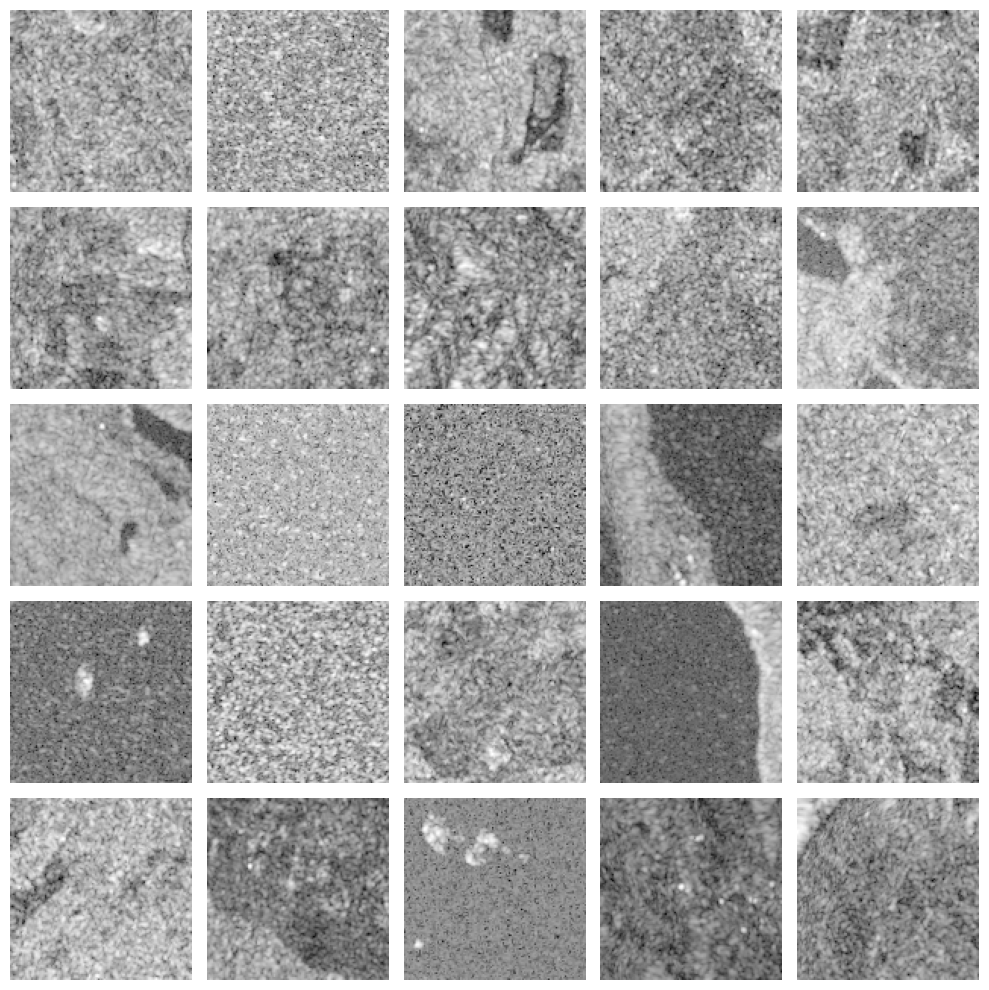

In [5]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['labels']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray") # one band 
    else:
        ax.imshow(img[...,0], cmap="gray") # first band
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
import pytorch_lightning as pl
from sklearn.metrics import average_precision_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from einops import rearrange
from pytorch_eo.tasks.classification import ImageMultilabelClassification
import timm
import torch

def clip(x, **kwargs): return np.clip(10**(x / 10), 0., 1.)
def add_channel(x, **kwargs): return rearrange(x, 'h w -> h w 1') if x.ndim == 2 else x

trans = A.Compose([
    A.Lambda(image=clip),    
    A.Lambda(image=add_channel),                           
    ToTensorV2()                                
])

ds = BigEarthNet(
    path="/fastdata/BigEarthNet", 
    batch_size=64, 
	bands={Sensors.S1: [S1.VH, S1.VV]}, # dict with sensor: bands
    label_groups=LABELS19,
    train_trans=trans, 
    val_trans=trans,
    num_workers=8,
    pin_memory=True,
)

model = timm.create_model('resnet18', pretrained=True, num_classes=ds.num_classes, in_chans=ds.in_chans)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

def my_map(y_hat, y):
    return average_precision_score(y.cpu(), torch.sigmoid(y_hat).detach().cpu(), average='micro')

task = ImageMultilabelClassification(model, hparams=hparams, metrics={'map': my_map} )

trainer = pl.Trainer(
    devices=1,
    accelerator='gpu',
    precision=16,
    max_epochs=3,
	limit_train_batches=100,
    limit_val_batches=100
)

torch.set_float32_matmul_precision('high') # more perf on some GPUs
trainer.fit(task, ds)

/home/juan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tens

Loading ... processed_S1_LABELS19.json


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
22.366    Total estimated model params size (MB)


Epoch 2: 100%|██████████| 200/200 [00:06<00:00, 31.20it/s, loss=0.243, v_num=32, map=0.677, val_loss=0.235, val_map=0.719]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 200/200 [00:06<00:00, 29.90it/s, loss=0.243, v_num=32, map=0.677, val_loss=0.235, val_map=0.719]


## Sentinel 2

In [7]:
from pytorch_eo.datasets.sensors import S2

ds = BigEarthNet(
    path="/fastdata/BigEarthNet",                       # path to dataset
    processed_data_path="data/BigEarthNet",             # path to save processed datafiles
    batch_size=25, 
	bands={Sensors.S2: [S2.red, S2.green, S2.blue]},    # use only S2 with RGB bands
    verbose=True,
    label_groups=LABELS19                               # group original labels in 19 superclasses
)

ds.setup()

Loading ... processed_S2_LABELS19.json
Training samples 354196
Validation samples 118065
Test samples 118065


In [8]:
ds.df

,s2_images,labels,encoded_labels
0,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Coniferous forest, Mixed forest, Transitional...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ..."
1,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Arable land, Coniferous forest, Mixed forest,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ..."
3,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Coniferous forest, Mixed forest]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
4,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Coniferous forest, Inland wetlands]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...
590321,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Arable land, Coniferous forest, Mixed forest,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
590322,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Land principally occupied by agriculture, wit...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ..."
590323,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
590324,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Arable land, Land principally occupied by agr...","[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, ..."


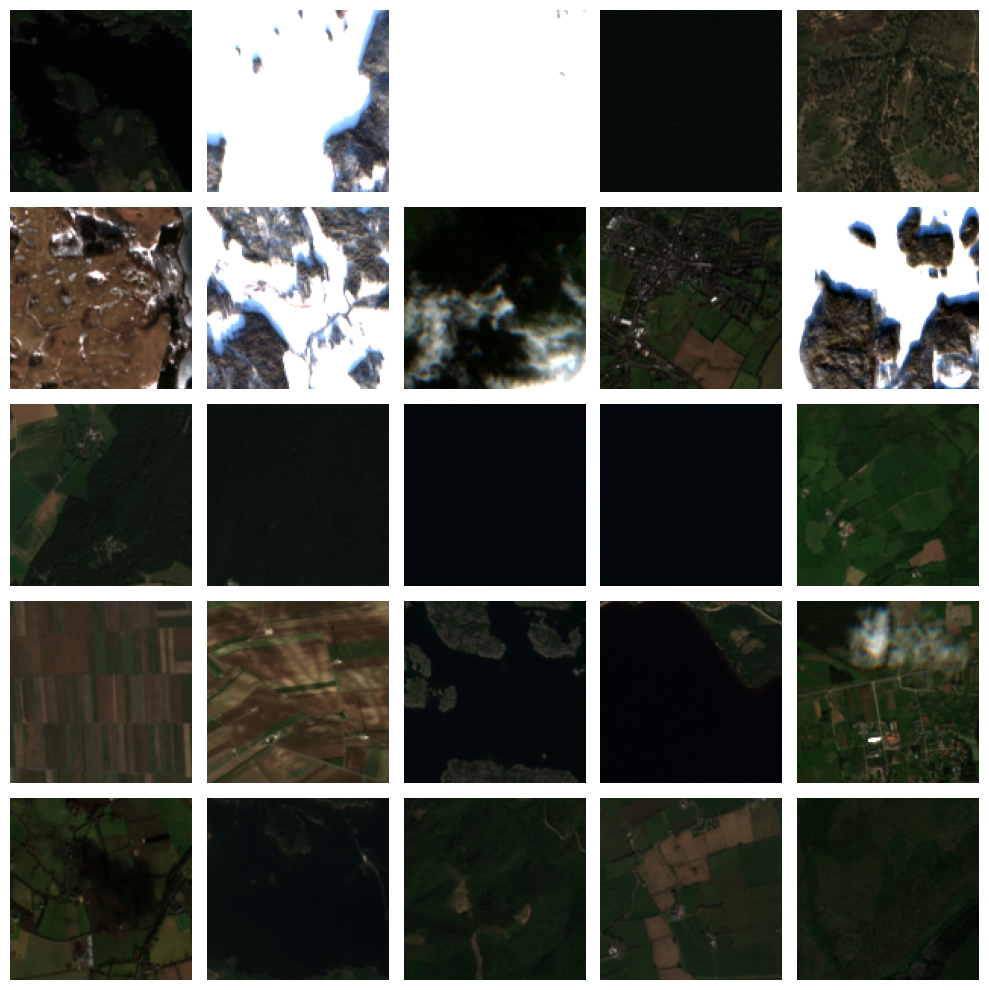

In [9]:
import matplotlib.pyplot as plt
from pytorch_eo.utils.image import to_uint8

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['labels']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    img = to_uint8(img, 0, 4000)
    ax.imshow(img) 
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
def clip(x, **kwargs): return np.clip(x / 4000, 0., 1.)
def add_channel(x, **kwargs): return rearrange(x, 'h w -> h w 1') if x.ndim == 2 else x

trans = A.Compose([
    A.Lambda(image=clip),    
    A.Lambda(image=add_channel),                           
    ToTensorV2()                                
])

ds = BigEarthNet(
    path="/fastdata/BigEarthNet", 
    batch_size=64, 
	bands={Sensors.S2: [S2.red, S2.green, S2.blue]}, # dict with sensor: bands
    label_groups=LABELS19,
    train_trans=trans, 
    val_trans=trans,
    num_workers=8,
    pin_memory=True,
)

model = timm.create_model('resnet18', pretrained=True, num_classes=ds.num_classes, in_chans=ds.in_chans)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

def my_map(y_hat, y):
    return average_precision_score(y.cpu(), torch.sigmoid(y_hat).detach().cpu(), average='micro')

task = ImageMultilabelClassification(model, hparams=hparams, metrics={'map': my_map} )

trainer = pl.Trainer(
    devices=1,
    accelerator='gpu',
    precision=16,
    max_epochs=3,
	limit_train_batches=100,
    limit_val_batches=100
)

torch.set_float32_matmul_precision('high') # more perf on some GPUs
trainer.fit(task, ds)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading ... processed_S2_LABELS19.json


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
22.373    Total estimated model params size (MB)


Epoch 2: 100%|██████████| 200/200 [00:08<00:00, 23.03it/s, loss=0.207, v_num=33, map=0.804, val_loss=0.207, val_map=0.785]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 200/200 [00:09<00:00, 22.19it/s, loss=0.207, v_num=33, map=0.804, val_loss=0.207, val_map=0.785]


## Data Fusion

We can use both input sources at the same time for Data Fusion applications.

In [11]:
ds = BigEarthNet(
    path="/fastdata/BigEarthNet",                       
    processed_data_path="data/BigEarthNet",             
    batch_size=5, 
	bands={
        Sensors.S1: [S1.VH, S1.VV],     
        Sensors.S2: [S2.red, S2.green, S2.blue]
    }, 
    label_groups=LABELS19,
    verbose=True
)

ds.setup()

Loading ... processed_S1_S2_LABELS19.json
Training samples 354196
Validation samples 118065
Test samples 118065


In [12]:
ds.df

,s1_images,s2_images,labels,encoded_labels
0,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Arable land, Coniferous forest, Mixed forest]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,[Pastures],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Arable land, Land principally occupied by agr...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Land principally occupied by agriculture, wit...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, ..."
...,...,...,...,...
590321,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Land principally occupied by agriculture, wit...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, ..."
590322,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Broad-leaved forest, Transitional woodland, s...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
590323,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Coniferous forest, Mixed forest, Inland waters]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
590324,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Arable land, Agro-forestry areas, Broad-leave...","[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."


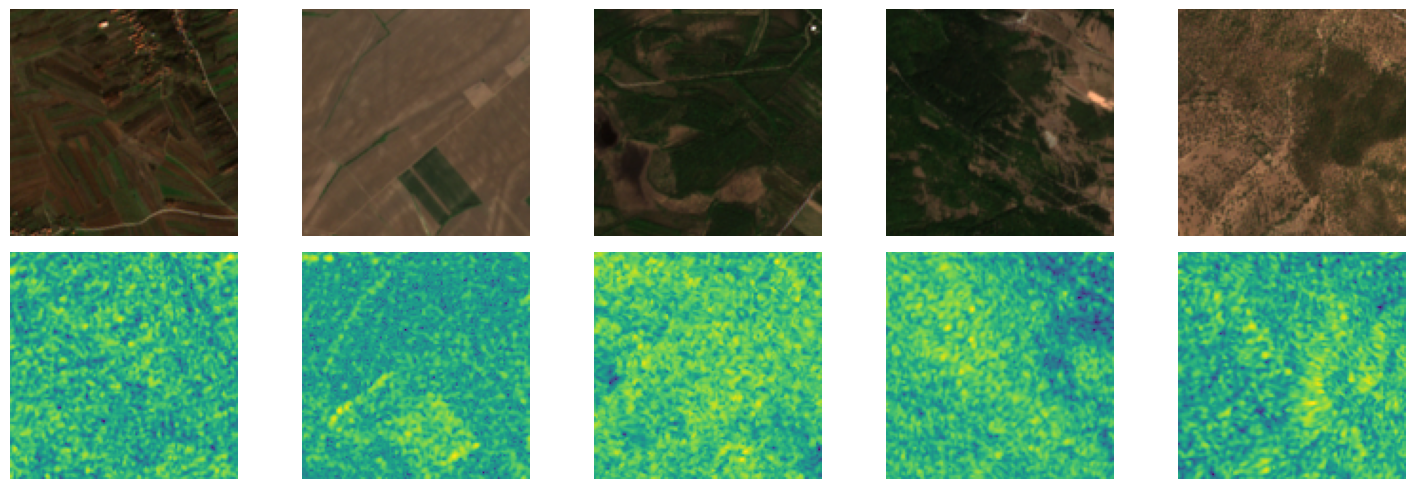

In [13]:
batch = next(iter(ds.train_dataloader()))

s1_imgs, s2_imgs, labels = batch['S1'], batch['S2'], batch['labels']

fig = plt.figure(figsize=(3*len(labels), 5))
th = 3000
for i, (s1, s2, label) in enumerate(zip(s1_imgs, s2_imgs, labels)):
	ax = plt.subplot(2, len(labels), i + 1)
	img = to_uint8(s2, 0, th)
	ax.imshow(img)
	ax.axis('off')
	ax = plt.subplot(2, len(labels), i + 1 + len(labels))
	ax.imshow(s1[...,0])
	ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
class Model(torch.nn.Module):

    def __init__(self, in_chans, num_classes, pretrained=None):
        super().__init__()
        self.model = timm.create_model(
            'resnet18',
            pretrained=pretrained,
            in_chans=in_chans,
            num_classes=num_classes
        )

    def forward(self, x):
        x1, x2 = x # S1, S2
        x1 = 10**(x1 / 10)
        x1 = x1.clip(0, 1)
        x2 = x2 / 4000
        x2 = x2.clip(0, 1)
        x = torch.cat([x1, x2], axis=1) # concatenate images on channels dimension
        return self.model(x)

In [23]:
trans = A.Compose([
    A.Lambda(image=add_channel),                           
    ToTensorV2()                                
], additional_targets={'S1': 'image', 'S2': 'image'}) # this should be handled by the library...

ds = BigEarthNet(
    path="/fastdata/BigEarthNet", 
    batch_size=32, 
	bands={
        Sensors.S1: [S1.VH, S1.VV],     
        Sensors.S2: [S2.red, S2.green, S2.blue]
    }, 
    label_groups=LABELS19,
    train_trans=trans,
    val_trans=trans,
    num_workers=8,
    pin_memory=True,
)

model = Model(in_chans=ds.in_chans, num_classes=ds.num_classes)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

task = ImageMultilabelClassification(model, hparams=hparams, metrics={'map': my_map} , inputs=['S1', 'S2'])

In [24]:
trainer = pl.Trainer(
    devices=1,
    accelerator='gpu',
    precision=16,
    max_epochs=3,
	limit_train_batches=100,
    limit_val_batches=100
)

trainer.fit(task, ds)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading ... processed_S1_S2_LABELS19.json


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Model             | 11.2 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
22.385    Total estimated model params size (MB)


Epoch 2: 100%|██████████| 200/200 [00:07<00:00, 26.97it/s, loss=0.285, v_num=37, map=0.587, val_loss=0.276, val_map=0.636]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 200/200 [00:07<00:00, 25.86it/s, loss=0.285, v_num=37, map=0.587, val_loss=0.276, val_map=0.636]


## Filter clouds and snow

BigEarthNet has a list of images with clouds and snow. You can filter them out from the dataset like this (only works if S2 images are used).

In [25]:
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.datasets.sensors import Sensors, S1, S2


ds = BigEarthNet(
    path="/fastdata/BigEarthNet", 
    batch_size=5, 
	bands={
        Sensors.S1: [S1.VH, S1.VV],     
        Sensors.S2: [S2.red, S2.green, S2.blue]
    }, 
    label_groups=LABELS19,
    verbose=True,
	filter_snow=True, # will remove ~60k images
    filter_clouds=True # will remove ~10k images
)

ds.setup()

Loading ... processed_S1_S2_LABELS19.json
Training samples 311605
Validation samples 103867
Test samples 103867


In [26]:
ds.df

,s1_images,s2_images,labels,encoded_labels
0,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Arable land, Coniferous forest, Mixed forest]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,[Pastures],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Arable land, Land principally occupied by agr...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Land principally occupied by agriculture, wit...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, ..."
...,...,...,...,...
590321,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Land principally occupied by agriculture, wit...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, ..."
590322,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Broad-leaved forest, Transitional woodland, s...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
590323,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Coniferous forest, Mixed forest, Inland waters]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
590324,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Arable land, Agro-forestry areas, Broad-leave...","[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
